In [1]:
import matplotlib.pyplot as plt
from helpers import *
torch.set_printoptions(precision=2,sci_mode=False, linewidth=200)

## Data Model

In [2]:
n_points = 400
n_features = 12
n_train_sets = 5
n_test_trials = 20
print("n_points:", n_points)
print("n_features:", n_features)

# Fix the variance to 1/n_features.
sig_sq = 1./n_features

# dist_sd_ratio = K, where norm(u-v) = K*sigma.
dist_sd_ratios = np.logspace(-1, .05 + .5*np.log(np.log(n_points)), num=100)
# dist_sd_ratios = np.linspace(1./10., 1.2*np.log(n_points), num=100)
data_model = {}
p = .5
q = .1
for K in dist_sd_ratios:
    data_model[K] = XCSBM(n_points, n_features, K, sig_sq, p, q)

n_points: 400
n_features: 12


## Training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
loss_fn = nn.BCELoss()
epochs = 1000

# Models.
mlps = {} # 2 layer MLPs
gcns_2l_1c = {} # 2 layer GCN with 1 GC at layer 1
gcns_2l_2c = {} # 2 layer GCN with 2 GCs at layer 2
train_loss_mlp = []
train_loss_gcn_2l = [[], []]

# Fix network architectures for the networks.
channels_2l = [[n_features, 4], [4, 1]]

print('Training', len(dist_sd_ratios), 'MLP and GCN models...')
for (j, K) in enumerate(dist_sd_ratios):
    print('\rWorking on', j+1, 'out of', len(dist_sd_ratios), 'datasets.', end='')
    data = data_model[K].generate_data()
    
    # 2-layer MLP
    # Initialize with ansatz based on u, v.
    model = MLP(n_layers=2, n_features=n_features, channels=channels_2l)
    set_params(model, data_model[K], n_layers=2)
    train_model(model, data, loss_fn, epochs=epochs)
    model.eval()
    out = model(data)
    loss = loss_fn(out, data.y.float())
    train_loss_mlp.append(loss.item())
    mlps[K] = model
    
    # 2-layer GCN with 1 GC at layer 1.
    # Initialize with ansatz based on u, v.
    model = GCN(n_layers=2, n_features=n_features, convolutions=[1, 0], channels=channels_2l)
    set_params(model, data_model[K], n_layers=2)
    for t in range(n_train_sets):
        data = data_model[K].generate_data()
        train_model(model, data, loss_fn, epochs=epochs, idx=str(j)+',GCN01')
    model.eval()
    out = model(data)
    loss = loss_fn(out, data.y.float())
    train_loss_gcn_2l[0].append(loss.item())
    gcns_2l_1c[K] = model
    
    # 2-layer GCN with 1 GC at layer 2.
    # Initialize with ansatz based on u, v.
    model = GCN(n_layers=2, n_features=n_features, convolutions=[0, 1], channels=channels_2l)
    set_params(model, data_model[K], n_layers=2)
    for t in range(n_train_sets):
        data = data_model[K].generate_data()
        train_model(model, data, loss_fn, epochs=epochs, idx=str(j)+',GCN02')
    model.eval()
    out = model(data)
    loss = loss_fn(out, data.y.float())
    train_loss_gcn_2l[1].append(loss.item())
    gcns_2l_2c[K] = model

Using device: cpu
Training 100 MLP and GCN models...
Idx: 99,GCN02 , Loss: 0.0009291830938309431

## Evaluation

In [6]:
test_loss_mlp = []
test_loss_gcn_2l = [[], []]
for K in dist_sd_ratios:
    loss_mlp = 0
    loss_gcn_2l = [0, 0]
    for t in range(n_test_trials):
        data = data_model[K].generate_data()
        
        # Loss of MLP on the test dataset.
        pred = mlps[K](data)
        loss_mlp += loss_fn(pred, data.y.float()).item()
        
        # Loss of GCNs on the test dataset.
        pred = gcns_2l_1c[K](data)
        loss_gcn_2l[0] += loss_fn(pred, data.y.float()).item()
        pred = gcns_2l_2c[K](data)
        loss_gcn_2l[1] += loss_fn(pred, data.y.float()).item()
    
    test_loss_mlp.append(loss_mlp/n_test_trials)
    test_loss_gcn_2l[0].append(loss_gcn_2l[0]/n_test_trials)
    test_loss_gcn_2l[1].append(loss_gcn_2l[1]/n_test_trials)

## Comparison of the Loss

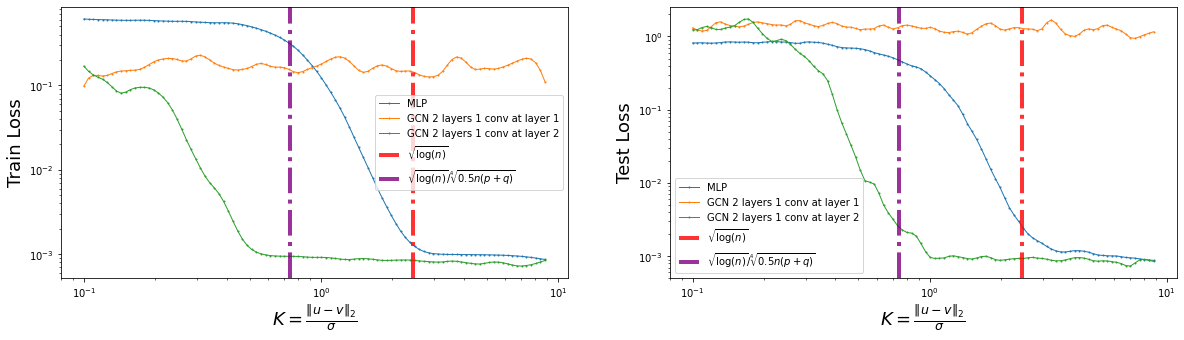

In [15]:
lw = 2 # line width for plots.
ms = 4 # marker size for plots.

fig = plt.figure(figsize=(20,5), facecolor=[1,1,1])
gs = fig.add_gridspec(1, 2, hspace=0)
axs = gs.subplots(sharex=True)
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    
axs[0].plot(dist_sd_ratios, train_loss_mlp, linewidth=lw, linestyle= '-', marker='.', markersize=ms, label='MLP')
axs[0].plot(dist_sd_ratios, train_loss_gcn_2l[0], linewidth=lw, linestyle= '-', marker='.', markersize=ms, label='GCN 2 layers 1 conv at layer 1')
axs[0].plot(dist_sd_ratios, train_loss_gcn_2l[1], linewidth=lw, linestyle= '-', marker='.', markersize=ms, label='GCN 2 layers 1 conv at layer 2')
axs[0].set_ylabel(r'Train Loss', fontsize=18)

axs[1].plot(dist_sd_ratios, test_loss_mlp, linewidth=lw, linestyle= '-', marker='.', markersize=ms, label='MLP')
axs[1].plot(dist_sd_ratios, test_loss_gcn_2l[0], linewidth=lw, linestyle= '-', marker='.', markersize=ms, label='GCN 2 layers 1 conv at layer 1')
axs[1].plot(dist_sd_ratios, test_loss_gcn_2l[1], linewidth=lw, linestyle= '-', marker='.', markersize=ms, label='GCN 2 layers 1 conv at layer 2')
axs[1].set_ylabel(r'Test Loss', fontsize=18)
for i in range(2):
    # axs[i].axvline(x=np.log(n_points), color='red', linewidth=4, linestyle='-.', alpha=0.5, label=r'$\log(n)$')
    axs[i].axvline(x=np.sqrt(np.log(n_points)), color='red', linewidth=4, linestyle='-.', alpha=.8, label=r'$\sqrt{\log(n)}$')
    axs[i].axvline(
        x=np.sqrt(np.log(n_points)/np.sqrt(.5*n_points*(p+q))),
        color='purple', linewidth=4, linestyle='-.', alpha=.8,
        label=r'$\sqrt{\log(n)}/\sqrt[4]{0.5n(p+q)}$')
    axs[i].set_xlabel(r'$K = \frac{\Vert u-v \Vert_2}{\sigma}$', fontsize=18)
    axs[i].legend()
fig.savefig("figures/synthetic_data_mlp_vs_gcn_conv_layer1.pdf", dpi=400, bbox_inches='tight')